# Libraries

In [1]:
import time
overall_start = time.time()         # <== Mark starting time
import os
from sys import argv, path
import sys
import datetime
import json
from torch import Tensor
import importlib

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn.functional as F

from lips import get_root_path
from lips.dataset.scaler.standard_scaler import StandardScaler
from lips.benchmark.airfransBenchmark import AirfRANSBenchmark
from lips.dataset.airfransDataSet import download_data

C:\Users\pc\AppData\Local\Temp\ipykernel_10824\265371401.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Importing the data

In [3]:
# indicate required paths
LIPS_PATH = get_root_path()
DIRECTORY_NAME = '../src/Dataset'
BENCHMARK_NAME = "Case1"
LOG_PATH = LIPS_PATH + "lips_logs.log"

In [4]:
root_dir = r"C:/Users/pc/Desktop/github/ml4physim/src/"

default_input_dir = root_dir + "Dataset"
default_output_dir = root_dir + "submission_attention/sample_result_submission"
default_program_dir = root_dir + "submission_attention"
default_submission_dir = root_dir + "submission_attention"
input_dir = default_input_dir
output_dir = default_output_dir
program_dir= default_program_dir
submission_dir= default_submission_dir
DIRECTORY_NAME = root_dir + 'Dataset'
BENCHMARK_NAME = "Case1"
LOG_PATH = root_dir + "lips_logs.log"
BENCH_CONFIG_PATH = os.path.join(root_dir, "LIPS","configurations","airfoil","benchmarks","confAirfoil.ini") #Configuration file related to the benchmark
SIM_CONFIG_PATH = os.path.join(submission_dir,"config.ini")
SAVE_PATH = os.path.join(output_dir,"AirfRANSModel")

In [5]:
# Load the required benchmark datasets, if it is not pickled, pickle it for future use
try:
    with open("C:/Users/pc/Desktop/github/ml4physim/benchmark.pkl", 'rb') as f:
        benchmark = pickle.load(f)
except:
    benchmark = AirfRANSBenchmark(benchmark_path=DIRECTORY_NAME,
                                  config_path=BENCH_CONFIG_PATH,
                                  benchmark_name=BENCHMARK_NAME,
                                  log_path=LOG_PATH)
    benchmark.load(path=DIRECTORY_NAME)
    with open('C:/Users/pc/Desktop/github/ml4physim/benchmark.pkl', 'wb') as f:
        pickle.dump(benchmark, f)

In [6]:
import datetime as dt
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from lips.dataset.scaler.standard_scaler_iterative import StandardScalerIterative

chunk_sizes=benchmark.train_dataset.get_simulations_sizes()
scalerParams={"chunk_sizes":chunk_sizes}
scaler = StandardScalerIterative(**scalerParams)

def process_dataset(dataset, training: bool) -> DataLoader:
    coord_x=dataset.data['x-position']
    coord_y=dataset.data['y-position']
    surf_bool=dataset.extra_data['surface']
    position = np.stack([coord_x,coord_y],axis=1)

    nodes_features,node_labels=dataset.extract_data()
    if training:
        print("Normalize train data")
        nodes_features, node_labels = scaler.fit_transform(nodes_features, node_labels)
        print("Transform done")
    else:
        print("Normalize not train data")
        nodes_features, node_labels = scaler.transform(nodes_features, node_labels)
        print("Transform done")

    torchDataset=[]
    nb_nodes_in_simulations = dataset.get_simulations_sizes()
    start_index = 0
    # check alive
    t = dt.datetime.now()

    for nb_nodes_in_simulation in nb_nodes_in_simulations:
        #still alive?
        if dt.datetime.now() - t > dt.timedelta(seconds=60):
            print("Still alive - index : ", end_index)
            t = dt.datetime.now()
        end_index = start_index+nb_nodes_in_simulation
        simulation_positions = torch.tensor(position[start_index:end_index,:], dtype = torch.float) 
        simulation_features = torch.tensor(nodes_features[start_index:end_index,:], dtype = torch.float) 
        simulation_labels = torch.tensor(node_labels[start_index:end_index,:], dtype = torch.float) 
        simulation_surface = torch.tensor(surf_bool[start_index:end_index])

        sampleData=Data(pos=simulation_positions,
                        x=simulation_features, 
                        y=simulation_labels,
                        surf = simulation_surface.bool()) 
        torchDataset.append(sampleData)
        start_index += nb_nodes_in_simulation
    
    return DataLoader(dataset=torchDataset,batch_size=1)

Data-loader used for the training

In [7]:
processed_data = process_dataset(benchmark.train_dataset, training=True)

Normalize train data
Transform done


## Some statistics about the dataset

In [8]:
# computing mean and standard deviation of the number of meshpoints per simumation
mean    = 0
std     = 0
n = len(processed_data.dataset)

for i in range(n):
    mean += processed_data.dataset[i].x.shape[0]
mean /= len(processed_data.dataset)

for i in range(n):
    std += (processed_data.dataset[i].x.shape[0] - mean)**2
std = np.sqrt(std/len(processed_data.dataset))

print(f"Number of datapoint per simulation - mean: {mean}, std: {std}")

IC_plus     = mean + 1.96*std/np.sqrt(n)
IC_minus    = mean - 1.96*std/np.sqrt(n)

print(f"Confidence interval at 95% of the size of the simulations: {IC_minus} - {IC_plus}")

n_sample = 32000
print(f"To have {n_sample} samples per cluster, one needs {mean/n_sample} +/- {1.96*std/(np.sqrt(n)*n_sample)} at the 95% confidence interval")

Number of datapoint per simulation - mean: 179761.31067961166, std: 6782.728771873349
Confidence interval at 95% of the size of the simulations: 178451.39931563594 - 181071.2220435874
To have 32000 samples per cluster, one needs 5.617540958737864 +/- 0.04093473012424166 at the 95% confidence interval


## K-means clustering

Because each simulation has too many points, using the global attention mechanism on each point of the simulation results in needing more than 100GB of memory.

This is not feasible.
One way of countering it would be to use batches that make use of the proximity of the points. That is, using a clustering algorithm to create batch-clusters and training our model per batch.

We can for instance use the K-means algorithm to create such clusters.

In [11]:
# K-means clustering

# using a uniform at random initialisation
def centroid_uniform_initialisation(X:Tensor, k: int=100):
    samples = np.random.choice(a=X.shape[0], replace=False, size=k)
    return X[samples,:]

# using the k-means++ initialisation
def kmeans_pp_initialisation(X: torch.Tensor, k: int):
    n_samples = X.shape[0]
    # Step 1: Choose one center uniformly at random from among the data points.
    centroids = X[torch.randint(0, n_samples, (1,))]

    for _ in range(k - 1):
        # Step 2: For each data point x, compute D(x), the distance between x and the nearest center that has already been chosen.
        distances = torch.cdist(X, centroids, p=2)
        min_distances = torch.min(distances, dim=1)[0]

        # Step 3: Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to D(x)^2.
        probabilities = min_distances / torch.sum(min_distances)
        new_centroid_idx = torch.multinomial(probabilities, 1)

        # Add the new centroid to the list of centroids
        centroids = torch.cat([centroids, X[new_centroid_idx]], dim=0)

    return centroids

def k_means(X:Tensor, k: int=6, n_iter: int=200):
    center = X.mean(0)
    centroids = kmeans_pp_initialisation(X,k)
    weights = (1/(((X - center)**2).sum(1) + 1e-15)).reshape(-1,1)
    weights = torch.ones(X.shape[0]).reshape(-1,1)

    for i in range(n_iter):
        # compute the distance of each point to the centroids
        distances = torch.cdist(X, centroids, p=2)

        # define the index associated to each centroid
        cluster_idx = torch.argmin(distances, dim=1)

        # compute the new centroids
        new_centroids = torch.stack([(weights[cluster_idx==i]*X[cluster_idx==i]).mean(0) for i in range(k)])

        # end when we have converged
        if torch.all(centroids == new_centroids):
            break

        centroids = new_centroids
    return cluster_idx

In [162]:
def cluster_id(X:Tensor, k: int=6, center:Tensor=torch.zeros(2)):
    
    angle = torch.arctan2(X[:,1] - center[0], X[:,0] - center[1]) + torch.pi
    index = k*angle/(2*torch.pi)
    return torch.floor(index).type(torch.int32)


def custom_clustering(X:Tensor, k: int=5, n_iter: int=200, radius: float=0.5):
    indices = torch.arange(X.shape[0])
    center = X.mean(0)

    center_mask = torch.sqrt(((X - center)**2).sum(1)) <= radius
    center_ids = indices[center_mask]
    other_ids = indices[~center_mask]
    center_points = X[center_ids]
    other_points = X[other_ids]

    center_clusters = k_means(center_points, k)
    other_clusters  = k_means(other_points, k) + k

    clusters = torch.zeros(X.shape[0], dtype=torch.int32)
    clusters[center_ids] = center_clusters.int()
    clusters[other_ids] = other_clusters.int()

    return clusters

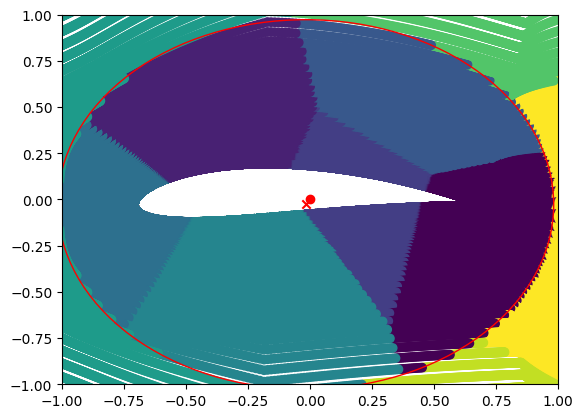

4     56854
0     37110
2     14940
11    11223
1      9149
6      8614
8      7019
5      6987
10     6473
7      4139
9      4131
3      3541
Name: count, dtype: int64

In [163]:
#scatter plot of X, with alphas to show the clusters and color the cluster using idx
import matplotlib.pyplot as plt

def plot_clusters(X, idx):
    plt.scatter(X[:,0], X[:,1], c=idx, alpha=1)

radius = 1.0
data = processed_data.dataset[0]
X = data.x[:,0:2]
cluster_idx = custom_clustering(X, 6, radius=radius)
center = X.mean(0)

plot_clusters(X, cluster_idx)
# add an x marker at the center of the figure
plt.scatter(center[0], center[1], c='r', marker='x')
plt.scatter(0,0, c='r', marker='o')

#plot circle of radius 0.5
circle = plt.Circle((center[0], center[1]), radius, color='r', fill=False)
plt.gca().add_artist(circle)

plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()
pd.Series(cluster_idx).value_counts()

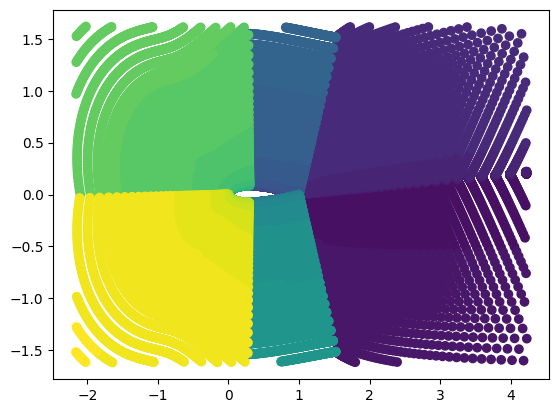

In [182]:
index = 18
X = processed_data.dataset[index].pos
n = int(X.shape[0]/50)

z = torch.arange(X.shape[0])
z = z//n
plot_clusters(X, z)

Text(0.5, 1.0, 'CDF of the distance from the center')

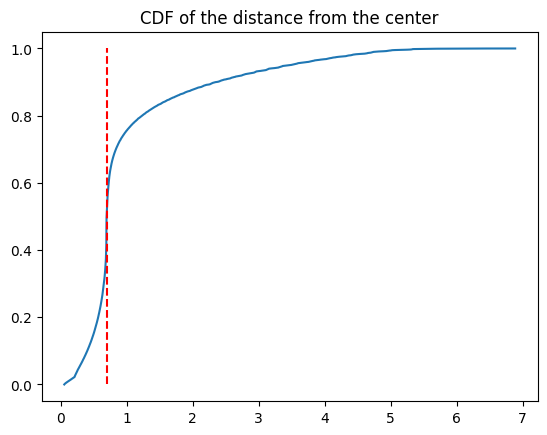

In [53]:
distance_from_center = torch.sqrt(((X - center)**2).sum(1, keepdim=False))

# plot the cdf of the distance from the center
sorted_distance = torch.sort(distance_from_center)[0]
plt.figure()
plt.plot(sorted_distance, )
plt.vlines(x = 0.7, ymin=0, ymax=1, color='r', linestyle='--')
plt.title("CDF of the distance from the center") 

In [92]:
buffer = []
for data in processed_data.dataset:
    X = data.pos
    center = X.mean(0)
    distance_from_center = torch.sqrt(((X - center)**2).sum(1, keepdim=False))
    sorted_distance = torch.sort(distance_from_center)[0]
    mask = (torch.linspace(0,1,sorted_distance.shape[0]) <= 0.5)
    sorted_distance[mask][-1]
    buffer.append(sorted_distance[mask][-1].item())

In [94]:
np.mean(buffer)

0.49773979881434766

In [98]:
np.mean(buffer) - 1.96*np.std(buffer)/np.sqrt(len(buffer))

0.496401283647313

In [95]:
np.std(buffer)

0.0069308394328906784

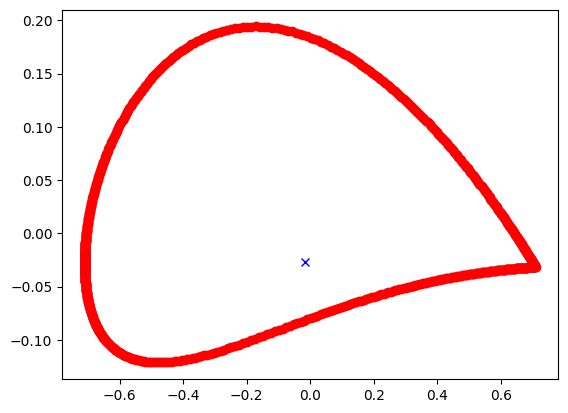

In [46]:
center = X.mean(0)
plt.plot(X[data.surf,0], X[data.surf,1], 'ro')
plt.plot(center[0], center[1], c='b', marker='x')

In [112]:
pd.Series(cluster_idx).value_counts()

0    170180
Name: count, dtype: int64

In [73]:
X[data]

tensor([[ 4.2169, -0.1999],
        [ 4.2169, -0.1999],
        [ 3.9918, -0.1859],
        ...,
        [-2.1285, -1.5419],
        [-2.1412, -1.5322],
        [-2.1539, -1.5222]])

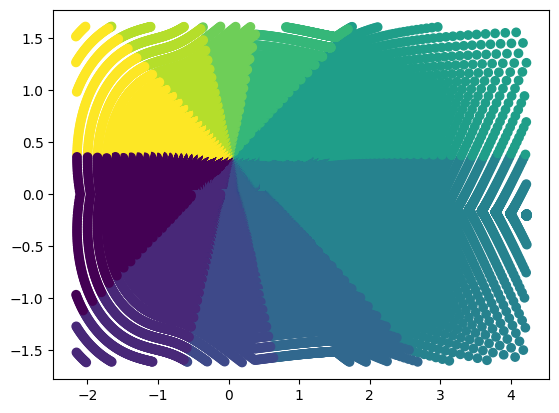

4    69619
2    60330
3    18596
1     8064
5     4905
0     2618
9     2533
8     1678
6     1263
7      574
Name: count, dtype: int64

In [74]:
def cluster_id(X:Tensor, k: int=6, center:Tensor=torch.zeros(2)):
    
    angle = torch.arctan2(X[:,1] - center[0], X[:,0] - center[1]) + torch.pi
    index = k*angle/(2*torch.pi)
    return torch.floor(index).type(torch.int32)

data = processed_data.dataset[0]
X = data.pos
center = X[data.surf].mean(0)
cluster_ids = cluster_id(X, k=10, center=center)
plot_clusters(X, cluster_ids)
pd.Series(cluster_ids).value_counts()

In [24]:
for cluster_id in cluster_idx.unique():
    initial_batch_ids = initial_ids[cluster_idx == cluster_id]
    batch_data = data[initial_batch_ids, :]
    batch_target = target[initial_batch_ids, :]
    

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [18]:
initial_ids

array([     0,   3473,   6946,  10419,  13892,  17365,  20838,  24311,
        27784,  31257,  34730,  38203,  41676,  45149,  48622,  52095,
        55568,  59041,  62514,  65987,  69460,  72933,  76406,  79879,
        83352,  86826,  90299,  93772,  97245, 100718, 104191, 107664,
       111137, 114610, 118083, 121556, 125029, 128502, 131975, 135448,
       138921, 142394, 145867, 149340, 152813, 156286, 159759, 163232,
       166705, 170179])

The points are concentrated arround the airfoil, so we don't have very balanced clusters...

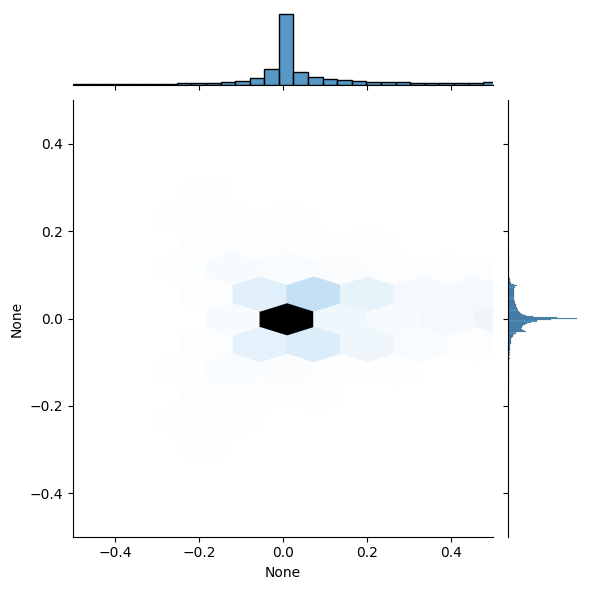

In [53]:
import seaborn as sns

#zoom around the airfoil
sns.jointplot(x=X[:,0], y=X[:,1], kind="hex", xlim=(-0.5,0.5), ylim=(-0.5,0.5))

We need to cluster our point-cloud and keep small sized clusters, without having too many...

# Trying torch-cluster?

In [251]:
import torch_cluster
from torch_cluster import grid_cluster, knn_graph